# Part 3: NNMF-based collaborative filtering
Design a NNMF-based collaborative filter to predict the ratings of the movies in the MovieLens dataset and evaluate it's performance using 10-fold cross-validation.

## Required libraries


In [1]:
from surprise import BaselineOnly

from surprise import Dataset

from surprise import Reader

from surprise.model_selection import cross_validate

import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import surprise

from surprise import accuracy

from surprise.model_selection import KFold



import sys, os

## Dataset

In [3]:
ratings = pd.read_csv('ratings.csv')

if not os.path.exists('results/Q17-22'):

    os.makedirs('results/Q17-22')

reader = Reader(rating_scale=(1, 5))

data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

ratings = ratings.as_matrix()

C:\Users\Omkar Mehta\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()


## Plot function for getting average RSME and MAE  vs No. of latent factors

In [4]:
def plot(k,metric_v,metric_name,type_data):

    x = range(2,k+2,2)

    plt.plot(x,metric_v)

    plt.xlabel("K")

    plt.ylabel("Average "+metric_name)

    plt.title("Average "+metric_name+" for k = "+str(k)+" for the "+type_data+" dataset")

    plt.savefig("Average "+metric_name+" for k = "+str(k)+" for the "+type_data+" dataset"+".png")
    
    plt.show()

    plt.close()

## Popular Trimmed testset
In this trimming, we trim the test set to contain
movies that has received more than 2 ratings. To be specific, if a movie
in the test set has received less than or equal to 2 ratings in the entire
dataset then we delete that movie from the test set and do not predict the
rating of that movie using the trained filter.

In [5]:
def popular_trim(array,dict):

    result = list()

    for i in range(0,len(array)):

        if(dict[array[i][1]] > 2):

            result.append(array[i])

    return result

## Unpopular trimmed testset

In this trimming, we trim the test set to
contain movies that has received less than or equal to 2 ratings. To be
specific, if a movie in the test set has received more than 2 ratings in
the entire dataset then we delete that movie from the test set and do not
predict the rating of that movie using the trained filter.

In [6]:
def unpop_trim(array,dict):

        result = list()

        for i in range(0,len(array)):

            if(dict[array[i][1]] <= 2):

                result.append(array[i])

        return result

## High variance trimmed testset

In this trimming, we trim the test set to
contain movies that has variance (of the rating values received) of at least
2 and has received at least 5 ratings in the entire dataset. To be specific,
if a movie has variance less than 2 or has received less than 5 ratings in
the entire dataset then we delete that movie from the test set and do not
predict the rating of that movie using the trained filter.

In [7]:
def high_var(array,dict,variance, map):

    result = list()

    for i in range(0,len(array)):

        if(dict[array[i][1]] > 5 and variance[map[array[i][1]]] >= 2):

            result.append(array[i])

    return result

## Dictionary of movieID as keys and Count as values

In [8]:
q3 = dict()

for i in range(0,ratings.shape[0]):

    if(ratings[i][1] not in q3):

        q3[ratings[i][1]] = 1

    else:

        q3[ratings[i][1]] = q3[ratings[i][1]]+1



## Dictionary of movieID as keys and index_numbers from 0 as values

In [9]:
counter = 0

map = dict()

for i in range(0,ratings.shape[0]):

    if(ratings[i][1] not in map):

        map[ratings[i][1]] = counter

        counter = counter +1
        


In [20]:
df = pd.DataFrame(map, index = [0])
len(df.columns)

9724

## Ratings matrix 

In [24]:
npdata = np.zeros((672,9724))

npdata[:] = np.nan

for i in range(0,ratings.shape[0]):

    npdata[ratings[i][0].astype(int)][map[ratings[i][1]]] = ratings[i][2]
    


## Variance matrix

In [25]:
q5 = np.square(np.nanstd(npdata,axis = 0))

## Using NMF for predicting movie ratings



In [27]:
res_test_mae = list()

res_test_rmse = list()

res_pop = list()

res_unpop = list()

res_high = list()

for k in range(2,52,2):

    kf = KFold(n_splits=10)

    temp_t_n = list()

    temp_t_r = list()

    temp_p = list()

    temp_u = list()

    temp_h = list()

    knn = surprise.prediction_algorithms.matrix_factorization.NMF(n_factors = k)

    for trainset, testset in kf.split(data):

        knn.fit(trainset)

        pop_test = popular_trim(testset,q3)

        unpop_test = unpop_trim(testset,q3)

        high_test = high_var(testset,q3,q5,map)

        predictions = knn.test(testset)

        temp_t_r.append(accuracy.rmse(predictions, verbose=False))

        temp_t_n.append(accuracy.mae(predictions, verbose=False))

        predictions = knn.test(pop_test)

        temp_p.append(accuracy.rmse(predictions, verbose=False))

        predictions = knn.test(unpop_test)

        temp_u.append(accuracy.rmse(predictions, verbose=False))

        predictions = knn.test(high_test)

        temp_h.append(accuracy.rmse(predictions, verbose=False))

    res_test_mae.append(np.average(temp_t_n))    

    res_test_rmse.append(np.average(temp_t_r))

    res_pop.append(np.average(temp_p))

    res_unpop.append(np.average(temp_u))

    res_high.append(np.average(temp_h))



## Plotting data

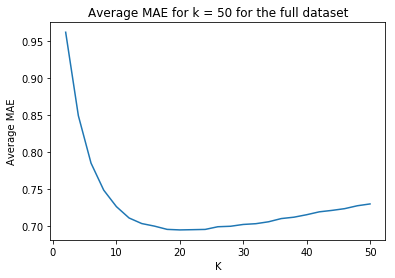

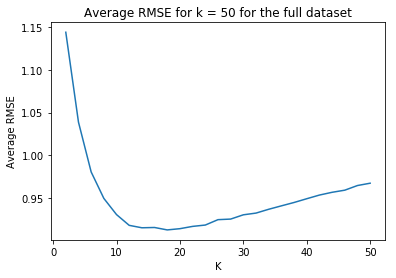

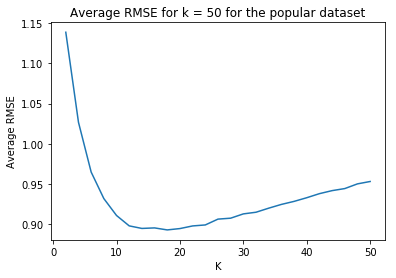

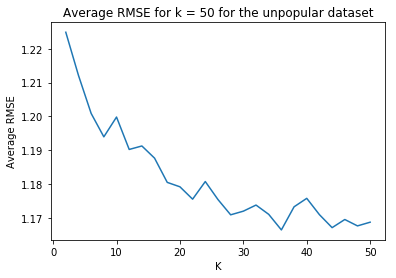

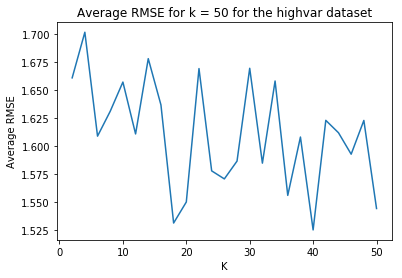

In [28]:
plot(50,res_test_mae,"MAE","full")

plot(50,res_test_rmse,"RMSE","full")

plot(50,res_pop,"RMSE","popular")

plot(50,res_unpop,"RMSE","unpopular")

plot(50,res_high,"RMSE","highvar")

## Performance evaluation using ROC curve

In [35]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
#using the best value of k
k = 17;

### Create trainset and testset

In [36]:
kf = KFold(n_splits=10)
y = list()
for trainset, testset in kf.split(data):
    knn = surprise.prediction_algorithms.matrix_factorization.NMF(n_factors = k)
    knn.fit(trainset)
    predictions = knn.test(testset)
    y = testset
    break

### Plot ROC curve function

In [37]:
def plot_roc(actual, predicted, k, threshold):
    x, y, _ = roc_curve(actual, predicted)
    print("AUC for k = " + str(k) + " and threshold = " + str(threshold) + ":")
    print(str(auc(x, y)))
    print()
    plt.plot(x, y, label="ROC Curve")
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title("ROC for k = " + str(k) + " and threshold = " + str(threshold))
    plt.legend(loc="best")
    plt.savefig("NMF_threshold_" + str(threshold) + "_k_" + str(k) + ".png")
    plt.show()
    plt.close()

### Prediction list on testset

In [38]:
pred=list()
for uid, iid, true_r, est, _ in predictions:
    pred.append(est)
    

### Actual list of testset

In [39]:
actual = list(np.array(y)[:,2])

### Plotting ROC curve for various thresholds

AUC for k = 17 and threshold = 2.5:
0.770921016758573



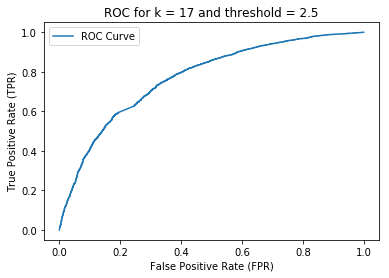

AUC for k = 17 and threshold = 3:
0.7612228989843236



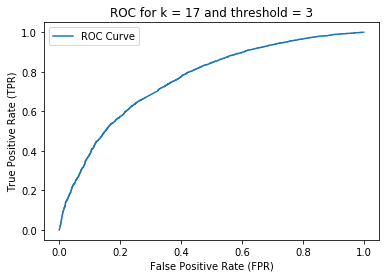

AUC for k = 17 and threshold = 3.5:
0.7598525491990024



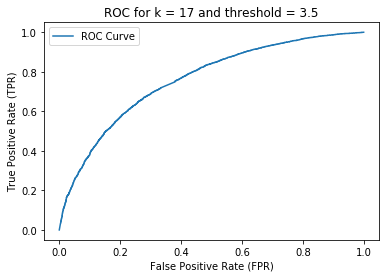

AUC for k = 17 and threshold = 4:
0.7562462175063522



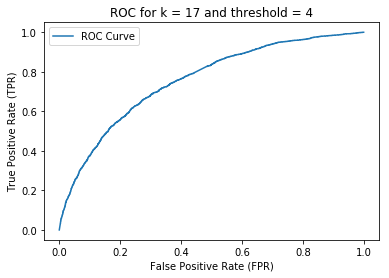

In [40]:
for threshold in [2.5,3,3.5,4]:
    testset_n = [None] *len(actual)
    for i in range(len(actual)):
        if actual[i]>threshold:
            testset_n[i] = 1
        elif actual[i] <= threshold:
            testset_n[i] = 0
    
    #testset_n=map(lambda x: 1 if x>threshold else 0,actual)
    plot_roc(testset_n, pred, k, threshold)
    actual = np.array(y)[:,2]

## Intrepretability of NMF 

Perform Non-negative matrix factorization on the ratings matrix
R to obtain the factor matrices U and V , where U represents the user-latent
factors interaction and V represents the movie-latent factors interaction (use k
= 20). For each column of V , sort the movies in descending order and report
the genres of the top 10 movies.

In [42]:
from sklearn.decomposition import NMF

In [43]:
nmf = NMF(n_components = 20)
nmf.fit(npdata)
w = nmf.components_

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
import heapq, itertools

## Creating Movie dataset

In [ ]:
movies = pd.read_csv('movies.csv')
movies = movies.as_matrix()

## Creating two dictionaries

map dictionary: Keys=MovieID, Values = Index from 0
rev_map dictionary: Keys = Index from 0, Values = MovieID

In [ ]:
counter = 0

map = dict()

rev_map = dict()

for i in range(0,ratings.shape[0]):
    if(ratings[i][1] not in map):
        rev_map[counter] = ratings[i][1] 
        map[ratings[i][1]] = counter
        counter = counter +1

## Getting genres 

In [ ]:
for i in range(0,w.shape[0]):
    a = w[i]
    result = heapq.nlargest(10, zip(a, itertools.count()))
    print("Genres for top 10 movies for component = "+str(i))
    for j in range(0,len(result)):
        for k in range(0,movies.shape[0]):
            if movies[k][0] == rev_map[result[j][1]]:
                print(movies[k][2])

    print()